In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import json, re, unicodedata, string, typing, time
import torch.nn.functional as F
import spacy
from collections import Counter
import pickle
from nltk import word_tokenize
nlp = spacy.load('en_core_web_sm')
from preprocess import *

In [2]:
# Read preprocessed data from pickle
train_df = pd.read_pickle('./dataset/qatrain.pkl')
test_df = pd.read_pickle('./dataset/qatest.pkl')

In [3]:
weights_matrix = np.load('./dataset/qaglove_vt.npy')
word2idx = np.load('./dataset/qa_word2idx.npy', allow_pickle=True).item()
idx2word = np.load('./dataset/qa_idx2word.npy', allow_pickle=True).item()
char2idx = np.load('./dataset/qa_char2idx.npy', allow_pickle=True).item()

In [4]:
class SquadDataset:
    '''
    -Divides the dataframe in batches.
    -Pads the contexts and questions dynamically for each batch by padding 
     the examples to the maximum-length sequence in that batch.
    -Calculates masks for context and question.
    -Calculates spans for contexts.
    '''
    
    def __init__(self, data, batch_size):
        
        self.batch_size = batch_size
        data = [data[i:i+self.batch_size] for i in range(0, len(data), self.batch_size)]
        self.data = data
    
    def get_span(self, text):
        
        text = nlp(text, disable=['parser','tagger','ner'])
        span = [(w.idx, w.idx+len(w.text)) for w in text]

        return span

    def __len__(self):
        return len(self.data)
    
    def __iter__(self):
        '''
        Creates batches of data and yields them.
        
        Each yield comprises of:
        :padded_context: padded tensor of contexts for each batch 
        :padded_question: padded tensor of questions for each batch 
        :context_mask & question_mask: zero-mask for question and context
        :label: start and end index wrt context_ids
        :context_text,answer_text: used while testing to calculate metrics
        :context_spans: spans of context text
        :ids: question_ids used in evaluation
        '''
        
        for batch in self.data:
                            
            spans = []
            context_text = []
            answer_text = []
            
            max_context_len = max([len(ctx) for ctx in batch.context_ids])
            padded_context = torch.LongTensor(len(batch), max_context_len).fill_(1)
            
            for ctx in batch.context:
                context_text.append(ctx)
                spans.append(self.get_span(ctx))
            
            for ans in batch.answer:
                answer_text.append(ans)
                
            for i, ctx in enumerate(batch.context_ids):
                padded_context[i, :len(ctx)] = torch.LongTensor(ctx)
            
            max_question_len = max([len(ques) for ques in batch.question_ids])
            padded_question = torch.LongTensor(len(batch), max_question_len).fill_(1)
            
            for i, ques in enumerate(batch.question_ids):
                padded_question[i,: len(ques)] = torch.LongTensor(ques)
                
            
            label = torch.LongTensor(list(batch.label_idx))
            context_mask = torch.eq(padded_context, 1)
            question_mask = torch.eq(padded_question, 1)
            
            ids = list(batch.id)  
            
            yield (padded_context, padded_question, context_mask, 
                   question_mask, label, context_text, answer_text, ids)
            
            

In [5]:
train_dataset = SquadDataset(train_df, 32)
test_dataset = SquadDataset(test_df, 32)

In [6]:
class AlignQuestionEmbedding(nn.Module):
    
    def __init__(self, input_dim):        
        
        super().__init__()
        
        self.linear = nn.Linear(input_dim, input_dim)
        
        self.relu = nn.ReLU()
        
    def forward(self, context, question, question_mask):
        
        # context = [bs, ctx_len, emb_dim]
        # question = [bs, qtn_len, emb_dim]
        # question_mask = [bs, qtn_len]
    
        ctx_ = self.linear(context)
        ctx_ = self.relu(ctx_)
        # ctx_ = [bs, ctx_len, emb_dim]
        
        qtn_ = self.linear(question)
        qtn_ = self.relu(qtn_)
        # qtn_ = [bs, qtn_len, emb_dim]
        
        qtn_transpose = qtn_.permute(0,2,1)
        # qtn_transpose = [bs, emb_dim, qtn_len]
        
        align_scores = torch.bmm(ctx_, qtn_transpose)
        # align_scores = [bs, ctx_len, qtn_len]
        
        qtn_mask = question_mask.unsqueeze(1).expand(align_scores.size())
        # qtn_mask = [bs, 1, qtn_len] => [bs, ctx_len, qtn_len]
        
        # Fills elements of self tensor(align_scores) with value(-float(inf)) where mask is True. 
        # The shape of mask must be broadcastable with the shape of the underlying tensor.
        align_scores = align_scores.masked_fill(qtn_mask == 1, -float('inf'))
        # align_scores = [bs, ctx_len, qtn_len]
        
        align_scores_flat = align_scores.view(-1, question.size(1))
        # align_scores = [bs*ctx_len, qtn_len]
        
        alpha = F.softmax(align_scores_flat, dim=1)
        alpha = alpha.view(-1, context.shape[1], question.shape[1])
        # alpha = [bs, ctx_len, qtn_len]
        
        align_embedding = torch.bmm(alpha, question)
        # align = [bs, ctx_len, emb_dim]
        
        return align_embedding

In [7]:
class StackedBiLSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        
        super().__init__()
        
        self.dropout = dropout
        
        self.num_layers = num_layers
        
        self.lstms = nn.ModuleList()
        
        for i in range(self.num_layers):
            
            input_dim = input_dim if i == 0 else hidden_dim * 2
            
            self.lstms.append(nn.LSTM(input_dim, hidden_dim,
                                      batch_first=True, bidirectional=True))
           
    
    def forward(self, x):
        # x = [bs, seq_len, feature_dim]

        outputs = [x]
        for i in range(self.num_layers):

            lstm_input = outputs[-1]
            lstm_out = F.dropout(lstm_input, p=self.dropout)
            lstm_out, (hidden, cell) = self.lstms[i](lstm_input)
           
            outputs.append(lstm_out)

    
        output = torch.cat(outputs[1:], dim=2)
        # [bs, seq_len, num_layers*num_dir*hidden_dim]
        
        output = F.dropout(output, p=self.dropout)
      
        return output

In [8]:
class LinearAttentionLayer(nn.Module):
    
    def __init__(self, input_dim):
        
        super().__init__()
        
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, question, question_mask):
        
        # question = [bs, qtn_len, input_dim] = [bs, qtn_len, bi_lstm_hid_dim]
        # question_mask = [bs,  qtn_len]
        
        qtn = question.view(-1, question.shape[-1])
        # qtn = [bs*qtn_len, hid_dim]
        
        attn_scores = self.linear(qtn)
        # attn_scores = [bs*qtn_len, 1]
        
        attn_scores = attn_scores.view(question.shape[0], question.shape[1])
        # attn_scores = [bs, qtn_len]
        
        attn_scores = attn_scores.masked_fill(question_mask == 1, -float('inf'))
        
        alpha = F.softmax(attn_scores, dim=1)
        # alpha = [bs, qtn_len]
        
        return alpha

In [9]:
def weighted_average(x, weights):
    # x = [bs, len, dim]
    # weights = [bs, len]
    
    weights = weights.unsqueeze(1)
    # weights = [bs, 1, len]
    
    w = weights.bmm(x).squeeze(1)
    # w = [bs, 1, dim] => [bs, dim]
    
    return w

In [10]:
class BilinearAttentionLayer(nn.Module):
    
    def __init__(self, context_dim, question_dim):
        
        super().__init__()
        
        self.linear = nn.Linear(question_dim, context_dim)
        
    def forward(self, context, question, context_mask):
        
        # context = [bs, ctx_len, ctx_hid_dim] = [bs, ctx_len, hid_dim*6] = [bs, ctx_len, 768]
        # question = [bs, qtn_hid_dim] = [bs, qtn_len, 768]
        # context_mask = [bs, ctx_len]
        
        qtn_proj = self.linear(question)
        # qtn_proj = [bs, ctx_hid_dim]
        
        qtn_proj = qtn_proj.unsqueeze(2)
        # qtn_proj = [bs, ctx_hid_dim, 1]
        
        scores = context.bmm(qtn_proj)
        # scores = [bs, ctx_len, 1]
        
        scores = scores.squeeze(2)
        # scores = [bs, ctx_len]
        
        scores = scores.masked_fill(context_mask == 1, -float('inf'))
        
        #alpha = F.log_softmax(scores, dim=1)
        # alpha = [bs, ctx_len]
        
        return scores

In [11]:
class DocumentReader(nn.Module):
    
    def __init__(self, hidden_dim, embedding_dim, num_layers, num_directions, dropout, device):
        
        super().__init__()
        
        self.device = device
        
        #self.embedding = self.get_glove_embedding()
        
        self.context_bilstm = StackedBiLSTM(embedding_dim * 2, hidden_dim, num_layers, dropout)
        
        self.question_bilstm = StackedBiLSTM(embedding_dim, hidden_dim, num_layers, dropout)
        
        self.glove_embedding = self.get_glove_embedding()
        
        def tune_embedding(grad, words=1000):
            grad[words:] = 0
            return grad
        
        self.glove_embedding.weight.register_hook(tune_embedding)
        
        self.align_embedding = AlignQuestionEmbedding(embedding_dim)
        
        self.linear_attn_question = LinearAttentionLayer(hidden_dim*num_layers*num_directions) 
        
        self.bilinear_attn_start = BilinearAttentionLayer(hidden_dim*num_layers*num_directions, 
                                                          hidden_dim*num_layers*num_directions)
        
        self.bilinear_attn_end = BilinearAttentionLayer(hidden_dim*num_layers*num_directions,
                                                        hidden_dim*num_layers*num_directions)
        
        self.dropout = nn.Dropout(dropout)
   
        
    def get_glove_embedding(self):
        
        num_embeddings, embedding_dim = weights_matrix.shape
        embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix).to(self.device),freeze=False)

        return embedding
    
    
    def forward(self, context, question, context_mask, question_mask):
       
        # context = [bs, len_c]
        # question = [bs, len_q]
        # context_mask = [bs, len_c]
        # question_mask = [bs, len_q]
        
        
        ctx_embed = self.glove_embedding(context)
        # ctx_embed = [bs, len_c, emb_dim]
        
        ques_embed = self.glove_embedding(question)
        # ques_embed = [bs, len_q, emb_dim]
        

        ctx_embed = self.dropout(ctx_embed)
     
        ques_embed = self.dropout(ques_embed)
             
        align_embed = self.align_embedding(ctx_embed, ques_embed, question_mask)
        # align_embed = [bs, len_c, emb_dim]  
        
        ctx_bilstm_input = torch.cat([ctx_embed, align_embed], dim=2)
        # ctx_bilstm_input = [bs, len_c, emb_dim*2]
                
        ctx_outputs = self.context_bilstm(ctx_bilstm_input)
        # ctx_outputs = [bs, len_c, hid_dim*layers*dir] = [bs, len_c, hid_dim*6]
       
        qtn_outputs = self.question_bilstm(ques_embed)
        # qtn_outputs = [bs, len_q, hid_dim*6]
    
        qtn_weights = self.linear_attn_question(qtn_outputs, question_mask)
        # qtn_weights = [bs, len_q]
            
        qtn_weighted = weighted_average(qtn_outputs, qtn_weights)
        # qtn_weighted = [bs, hid_dim*6]
        
        start_scores = self.bilinear_attn_start(ctx_outputs, qtn_weighted, context_mask)
        # start_scores = [bs, len_c]
         
        end_scores = self.bilinear_attn_end(ctx_outputs, qtn_weighted, context_mask)
        # end_scores = [bs, len_c]
        
      
        return start_scores, end_scores

In [12]:
device = torch.device('cuda')
HIDDEN_DIM = 128
EMB_DIM = 300
NUM_LAYERS = 3
NUM_DIRECTIONS = 2
DROPOUT = 0.3

model = DocumentReader(HIDDEN_DIM,
                       EMB_DIM, 
                       NUM_LAYERS, 
                       NUM_DIRECTIONS, 
                       DROPOUT, 
                       device).to(device)

In [13]:
optimizer = torch.optim.Adamax(model.parameters())

In [14]:
def count_parameters(model):
    '''Returns the number of trainable parameters in the model.'''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,183,349 trainable parameters


In [15]:
def train(model, train_dataset):
    '''
    Trains the model.
    '''
    
    print("Starting training ........")
    
    train_loss = 0.
    batch_count = 0
    
    # put the model in training mode
    model.train()
    
    predictions = {}
    # iterate through training data
    for batch in train_dataset:

        if batch_count % 500 == 0:
            print(f"Starting batch: {batch_count}")
        batch_count += 1

        context, question, context_mask, question_mask, label, ctx, ans, ids = batch
        
        # place the tensors on GPU
        context, context_mask, question, question_mask, label = context.to(device), context_mask.to(device),\
                                    question.to(device), question_mask.to(device), label.to(device)
        
        # forward pass, get the predictions
        preds = model(context, question, context_mask, question_mask)

        start_pred, end_pred = preds
        
        # separate labels for start and end position
        start_label, end_label = label[:,0], label[:,1]
        
        # calculate loss
        loss = F.cross_entropy(start_pred, start_label) + F.cross_entropy(end_pred, end_label)
        
        # backward pass, calculates the gradients
        loss.backward()
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        
        # update the gradients
        optimizer.step()
        
        # zero the gradients to prevent them from accumulating
        optimizer.zero_grad()

        train_loss += loss.item()
        
        
        # get the start and end index positions from the model preds

        batch_size, c_len = start_pred.size()
        ls = nn.LogSoftmax(dim=1)
        mask = (torch.ones(c_len, c_len) * float('-inf')).to(device).tril(-1).unsqueeze(0).expand(batch_size, -1, -1)

        score = (ls(start_pred).unsqueeze(2) + ls(end_pred).unsqueeze(1)) + mask
        score, s_idx = score.max(dim=1)
        score, e_idx = score.max(dim=1)
        s_idx = torch.gather(s_idx, 1, e_idx.view(-1, 1)).squeeze()

        # stack predictions
        for i in range(batch_size):
            id = ids[i]
            pred = context[i][s_idx[i]:e_idx[i]+1]
            pred = ' '.join([idx2word[idx.item()] for idx in pred])
            predictions[id] = pred
            
        
    em, f1 = evaluate(predictions, "train") 
    return train_loss/len(train_dataset), em, f1

In [16]:
def test(model, test_dataset):
    '''
    Performs Testing.
    '''
    
    print("Starting Testing .........")
   
    test_loss = 0.

    batch_count = 0
    
    f1, em = 0., 0.
    
    # puts the model in eval mode. Turns off dropout
    model.eval()
    
    predictions = {}
    
    for batch in test_dataset:

        if batch_count % 500 == 0:
            print(f"Starting batch {batch_count}")
        batch_count += 1

        context, question, context_mask, question_mask, label, context_text, answers, ids = batch

        context, context_mask, question, question_mask, label = context.to(device), context_mask.to(device),\
                                    question.to(device), question_mask.to(device), label.to(device)

        with torch.no_grad():

            preds = model(context, question, context_mask, question_mask)

            p1, p2 = preds

            y1, y2 = label[:,0], label[:,1]

            loss = F.cross_entropy(p1, y1) + F.cross_entropy(p2, y2)

            test_loss += loss.item()

            
            # get the start and end index positions from the model preds
            
            batch_size, c_len = p1.size()
            ls = nn.LogSoftmax(dim=1)
            mask = (torch.ones(c_len, c_len) * float('-inf')).to(device).tril(-1).unsqueeze(0).expand(batch_size, -1, -1)
            
            score = (ls(p1).unsqueeze(2) + ls(p2).unsqueeze(1)) + mask
            score, s_idx = score.max(dim=1)
            score, e_idx = score.max(dim=1)
            s_idx = torch.gather(s_idx, 1, e_idx.view(-1, 1)).squeeze()
            
            # stack predictions
            for i in range(batch_size):
                id = ids[i]
                pred = context[i][s_idx[i]:e_idx[i]+1]
                pred = ' '.join([idx2word[idx.item()] for idx in pred])
                predictions[id] = pred
            
            
            
    em, f1 = evaluate(predictions, "test")            
    return test_loss/len(test_dataset), em, f1

In [17]:
with open('./dataset/squad_test.json','r',encoding='utf-8') as f:
    test_ds = json.load(f)['data']
with open('./dataset/squad_train.json','r',encoding='utf-8') as f:
    train_ds = json.load(f)['data']

In [18]:
def evaluate(predictions, stage):
    '''
    Gets a dictionary of predictions with question_id as key
    and prediction as value. The test dataset has multiple 
    answers for a single question. Hence we compare our prediction
    with all the answers and choose the one that gives us
    the maximum metric (em or f1). 
    This method first parses the JSON file, gets all the answers
    for a given id and then passes the list of answers and the 
    predictions to calculate em, f1.
    
    
    :param dict predictions
    Returns
    : exact_match: 1 if the prediction and ground truth 
      match exactly, 0 otherwise.
    : f1_score: 
    '''
    if stage == "train":
        dataset = train_ds
    else:
        dataset = test_ds
    
    f1 = exact_match = total = 0
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                total += 1
                if qa['id'] not in predictions:
                    continue
                
                ground_truths = list(map(lambda x: x['text'], qa['answers']))
                
                prediction = predictions[qa['id']]
                
                exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
                
                f1 += metric_max_over_ground_truths(
                    f1_score, prediction, ground_truths)
                
    
    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total
    
    return exact_match, f1

In [19]:
def normalize_answer(s):
    '''
    Performs a series of cleaning steps on the ground truth and 
    predicted answer.
    '''
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    '''
    Returns maximum value of metrics for predicition by model against
    multiple ground truths.
    
    :param func metric_fn: can be 'exact_match_score' or 'f1_score'
    :param str prediction: predicted answer span by the model
    :param list ground_truths: list of ground truths against which
                               metrics are calculated. Maximum values of 
                               metrics are chosen.
                            
    
    '''
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
        
    return max(scores_for_ground_truths)


def f1_score(prediction, ground_truth):
    '''
    Returns f1 score of two strings.
    '''
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    '''
    Returns exact_match_score of two strings.
    '''
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def epoch_time(start_time, end_time):
    '''
    Helper function to record epoch time.
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
train_losses = []
test_losses = []
train_ems = []
train_f1s = []
test_ems = []
test_f1s = []
epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    
    start_time = time.time()
    
    train_loss, train_em, train_f1 = train(model, train_dataset)
    test_loss, test_em, test_f1 = test(model, test_dataset)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_ems.append(train_em)
    train_f1s.append(train_f1)
    test_ems.append(test_em)
    test_f1s.append(test_f1)
    
    print(f"Epoch train loss : {train_loss} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"Epoch test loss: {test_loss}")
    print(f"Epoch train EM: {train_em} | test EM: {test_em}")
    print(f"Epoch train F1: {train_f1} | test F1: {test_f1}")
    print("====================================================================================")

Epoch 1
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
Starting batch: 1500
Starting batch: 2000
Starting batch: 2500
Starting Testing .........
Starting batch 0
Starting batch 500
Starting batch 1000
Epoch train loss : 4.899861683705898 | Time: 6m 33s
Epoch test loss: 3.9175785493985282
Epoch train EM: 28.1384490690533 | test EM: 47.1050141911069
Epoch train F1: 42.03843423807621 | test F1: 59.10267450857869
Epoch 2
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
Starting batch: 1500
Starting batch: 2000
Starting batch: 2500
Starting Testing .........
Starting batch 0
Starting batch 500
Starting batch 1000
Epoch train loss : 3.611377337095559 | Time: 7m 8s
Epoch test loss: 3.578200525533222
Epoch train EM: 41.52558819164602 | test EM: 52.857142857142854
Epoch train F1: 56.36280473976995 | test F1: 64.4969987945746
Epoch 3
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
St

Starting batch: 2000
Starting batch: 2500
Starting Testing .........
Starting batch 0
Starting batch 500
Starting batch 1000
Epoch train loss : 1.3883973636489784 | Time: 6m 33s
Epoch test loss: 4.147978966233872
Epoch train EM: 67.5898126690944 | test EM: 56.783349101229895
Epoch train F1: 80.31378405734817 | test F1: 68.39380544786566
Epoch 17
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
Starting batch: 1500
Starting batch: 2000
Starting batch: 2500
Starting Testing .........
Starting batch 0
Starting batch 500
Starting batch 1000
Epoch train loss : 1.3268424454245238 | Time: 6m 33s
Epoch test loss: 4.273158263818116
Epoch train EM: 68.36607723832464 | test EM: 56.792809839167454
Epoch train F1: 80.93793368761897 | test F1: 68.33419727448789
Epoch 18
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
Starting batch: 1500
Starting batch: 2000
Starting batch: 2500
Starting Testing .........
Starting batch 0
Sta

In [21]:
# Save model
torch.save(model.state_dict(), './model/model_stacked_bilstm.h5')

In [21]:
device = torch.device('cuda')
HIDDEN_DIM = 128
EMB_DIM = 300
NUM_LAYERS = 3
NUM_DIRECTIONS = 2
DROPOUT = 0.3

model_copy = DocumentReader(HIDDEN_DIM,
                       EMB_DIM, 
                       NUM_LAYERS, 
                       NUM_DIRECTIONS, 
                       DROPOUT, 
                       device)
model_copy.load_state_dict(torch.load('./model/model_stacked_bilstm.h5'))
model_copy.eval()

DocumentReader(
  (context_bilstm): StackedBiLSTM(
    (lstms): ModuleList(
      (0): LSTM(600, 128, batch_first=True, bidirectional=True)
      (1): LSTM(256, 128, batch_first=True, bidirectional=True)
      (2): LSTM(256, 128, batch_first=True, bidirectional=True)
    )
  )
  (question_bilstm): StackedBiLSTM(
    (lstms): ModuleList(
      (0): LSTM(300, 128, batch_first=True, bidirectional=True)
      (1): LSTM(256, 128, batch_first=True, bidirectional=True)
      (2): LSTM(256, 128, batch_first=True, bidirectional=True)
    )
  )
  (glove_embedding): Embedding(110474, 300)
  (align_embedding): AlignQuestionEmbedding(
    (linear): Linear(in_features=300, out_features=300, bias=True)
    (relu): ReLU()
  )
  (linear_attn_question): LinearAttentionLayer(
    (linear): Linear(in_features=768, out_features=1, bias=True)
  )
  (bilinear_attn_start): BilinearAttentionLayer(
    (linear): Linear(in_features=768, out_features=768, bias=True)
  )
  (bilinear_attn_end): BilinearAttentionLay

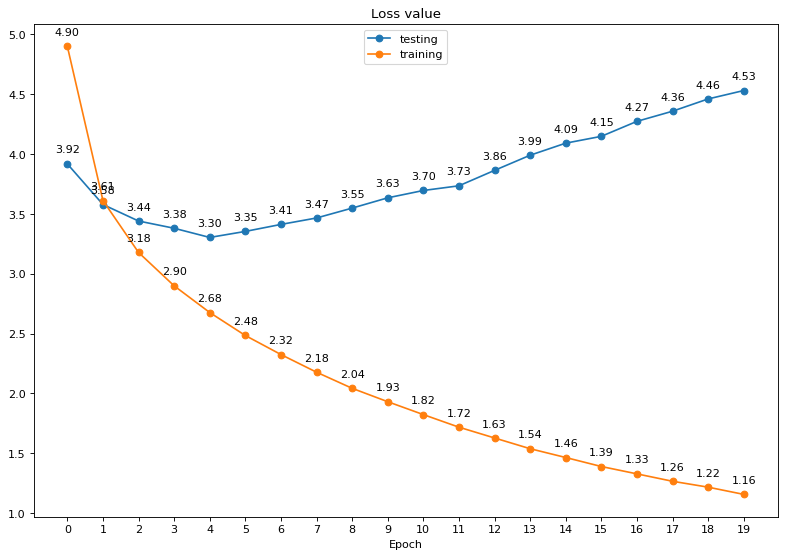

In [46]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8), dpi=80)
# plt.subplot(211)
plt.plot(test_losses, label="testing", marker='o')
x=0
for y in test_losses:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1

plt.plot(train_losses,label="training", marker='o')
x=0
for y in train_losses:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1
# plt.yticks([0.10,0.30,0.50,0.70])
plt.xticks(range(0,20))
plt.title('Loss value',fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.legend(loc='upper center')
# ax.legend()
plt.show()

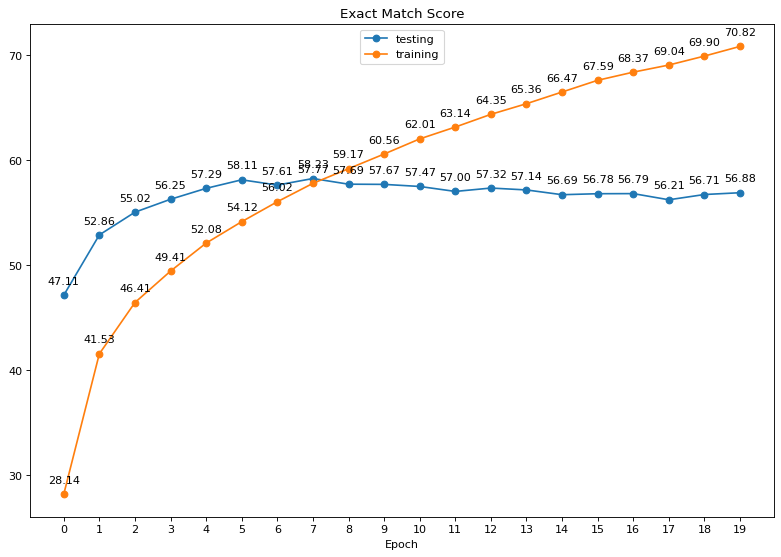

In [47]:
plt.figure(figsize=(12, 8), dpi=80)
# plt.subplot(211)
plt.plot(test_ems, label="testing", marker='o')
x=0
for y in test_ems:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1

plt.plot(train_ems,label="training", marker='o')
x=0
for y in train_ems:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1
# plt.yticks([0.10,0.30,0.50,0.70])
plt.xticks(range(0,20))
plt.title('Exact Match Score',fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.legend(loc='upper center')
# ax.legend()
plt.show()

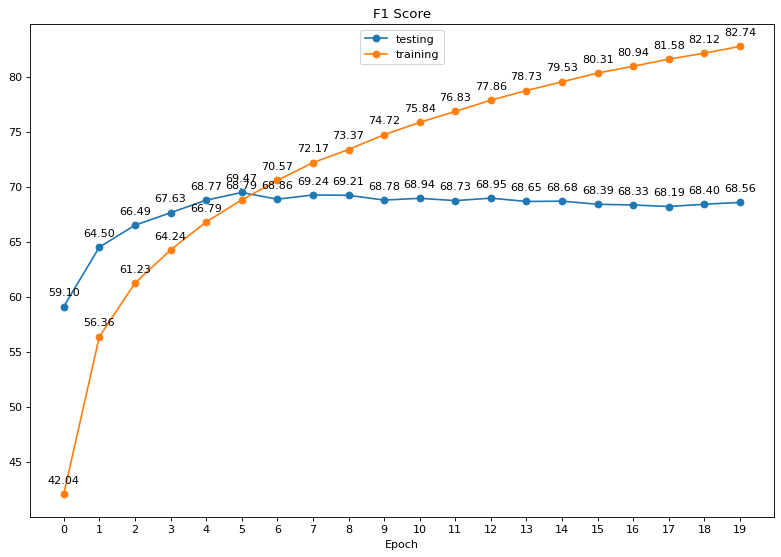

In [48]:
plt.figure(figsize=(12, 8), dpi=80)
# plt.subplot(211)
plt.plot(test_f1s, label="testing", marker='o')
x=0
for y in test_f1s:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1

plt.plot(train_f1s,label="training", marker='o')
x=0
for y in train_f1s:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1
# plt.yticks([0.10,0.30,0.50,0.70])
plt.xticks(range(0,20))
plt.title('F1 Score',fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.legend(loc='upper center')
# ax.legend()
plt.show()